# Plane's Windows

#### This exercices aims to build an algorithm to detect windows which are abnormal.

1/ With this information and no more, formulate the problem, and tell him what is feasible and what is not.

2/ Develop an approach to answer his question in the best way possible.

3/ Present your findings to the expert, in a way he can understand and help you validate your results...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
data = pd.read_csv("./data/dataset.csv")

df = data.drop(columns=["day_cycle_window"])

n = data.shape[0]

data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237


In [3]:
def plotAnomalyScore2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df)
    
    for col in df.columns :
        fig = plt.figure()
        plot = plt.scatter(x=range(n), y=df[col], marker='.', c=-score, cmap='Reds')
        plt.colorbar(plot, label='anomaly score')
        plt.xlabel("Samples")
        plt.ylabel("Values")
        plt.title(clf_name + "\n" + col)

### Graphes des échantillons pour chacune des variables

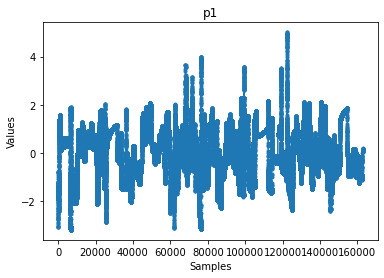

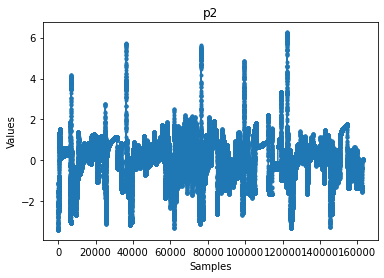

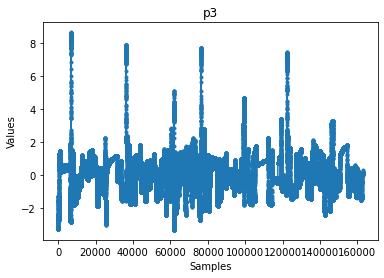

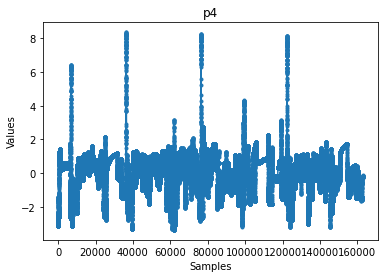

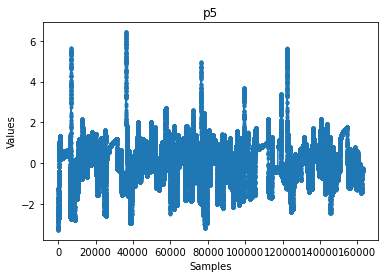

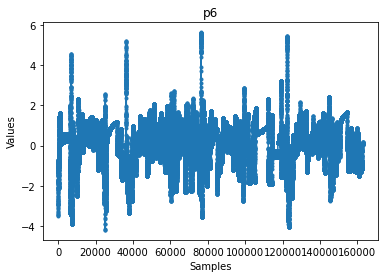

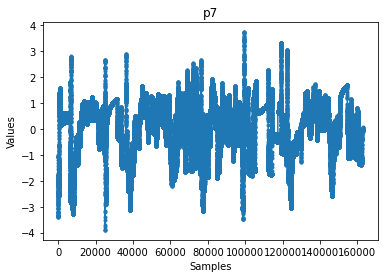

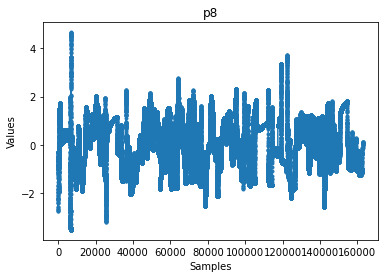

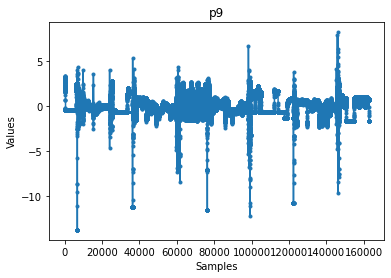

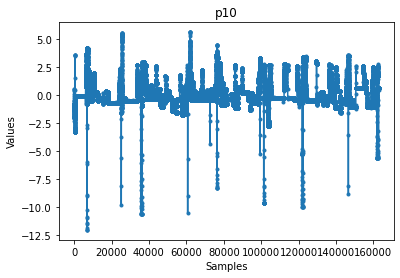

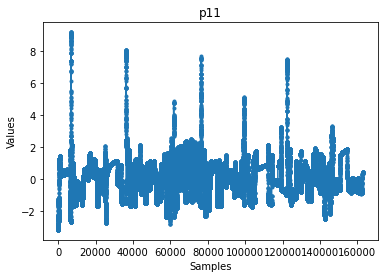

In [4]:
for col in df.columns :
    fig = plt.figure()
    plt.plot(df[col], marker='.')
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.title(col)

# Méthodes Outliers

### Distance de Mahalanobis

In [5]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df)

EllipticEnvelope(contamination=0.15)

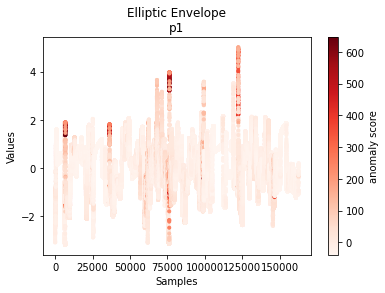

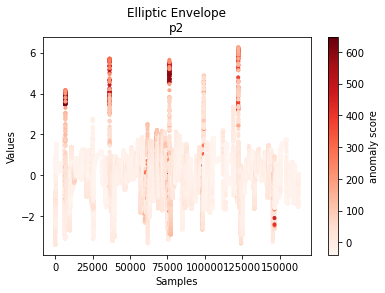

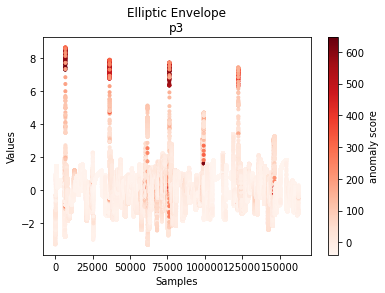

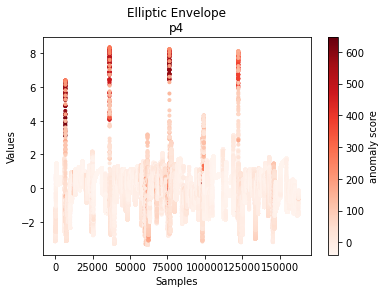

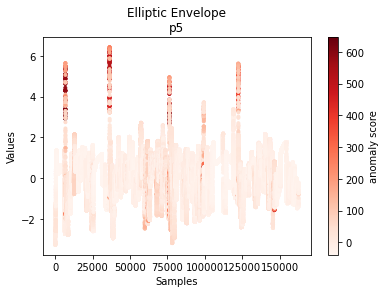

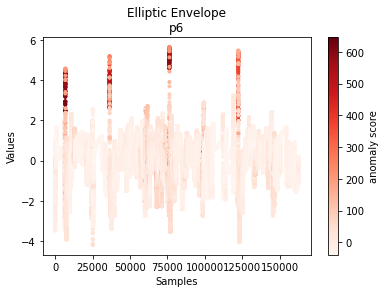

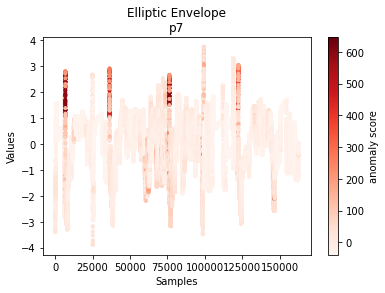

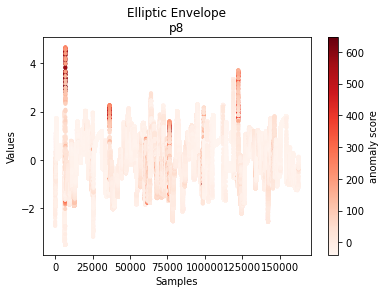

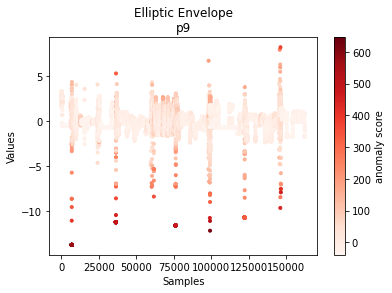

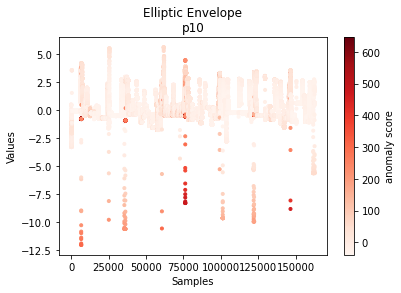

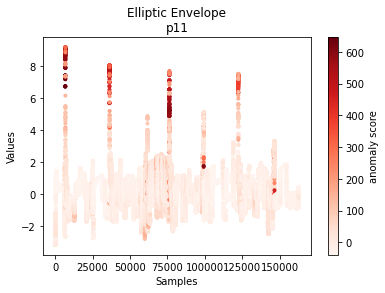

In [6]:
plotAnomalyScore2D(df, clf_name, clf)

### Méthode d'Isolation Forest

In [7]:
clf_name = 'Isolation Forest'
clf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.15)
clf.fit(df)

/home/cdrutinus/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


IsolationForest(behaviour='new', contamination=0.15)

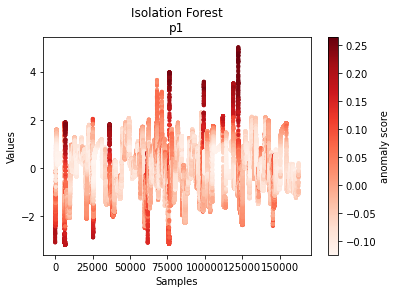

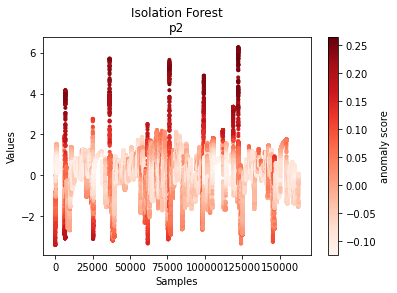

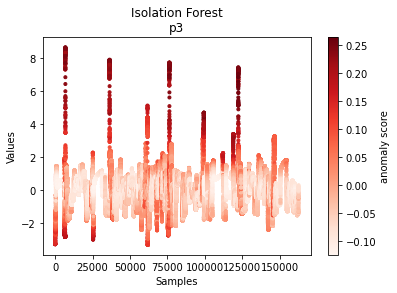

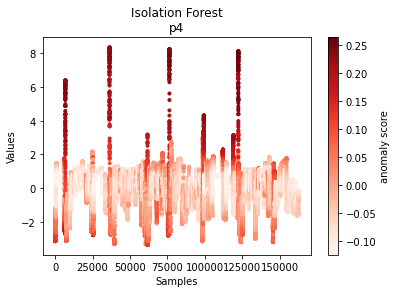

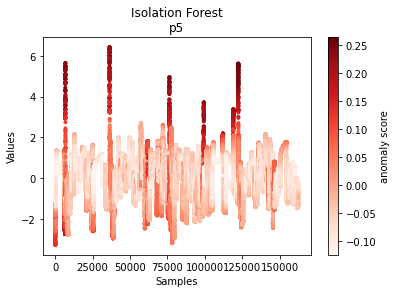

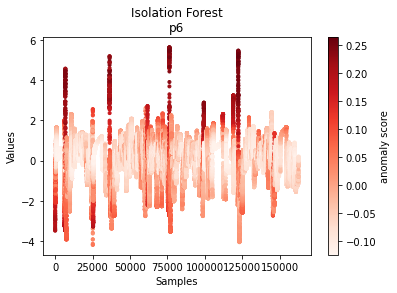

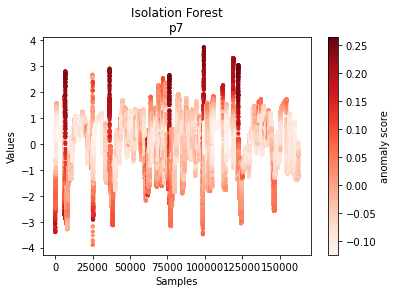

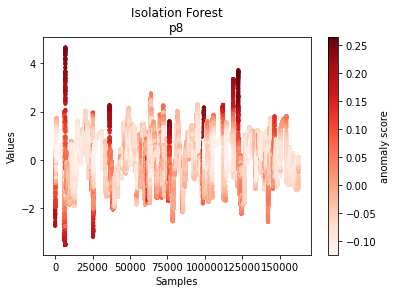

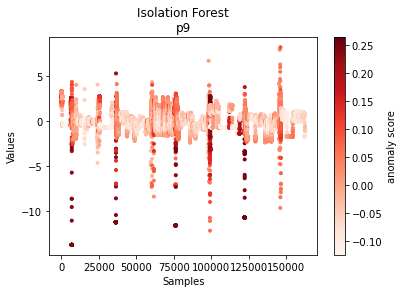

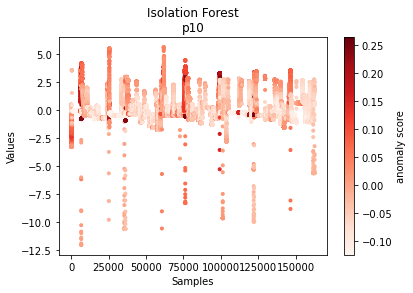

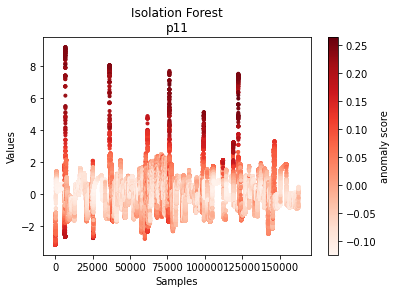

In [8]:
plotAnomalyScore2D(df, clf_name, clf)